In [1]:
# Использовать лямбда-слой для обертывания произвольных
# выражений как Layer объект
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model


import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec

from random import random, randrange, randint
from sklearn.metrics import roc_auc_score
from IPython.display import clear_output

import os

import random
from random import random, randrange, randint

In [2]:
# Загружаем данные для тренировки
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train  / 255.0
x_test = x_test / 255.0

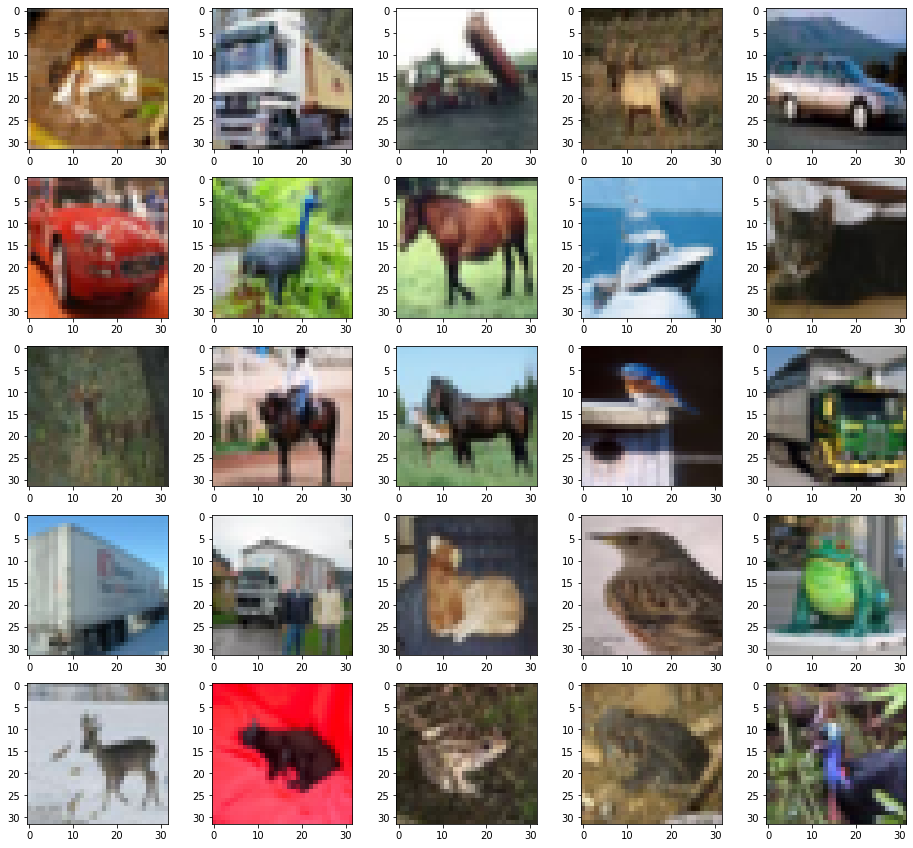

In [3]:
# Показываем изображения

num_row = 5 
num_col = 5
# построить изображения
fig, axes = plt.subplots(num_row, num_col, figsize=(3.2*num_col,3*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax. imshow(x_train[i], cmap='gray') 

In [4]:
x_train[0]

array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

In [5]:
input_dim = (32,32,3)
latent_dim = 256

In [6]:
# Функция расчета среднего и матожидания
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

(None, 32, 32, 3)
(None, 14, 14, 32)
(None, 5, 5, 64)
(None, 1600)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Encoder (InputLayer)     [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   896         ['Input_Encoder[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 32)   0           ['conv2d_1[0][0]']               
                         

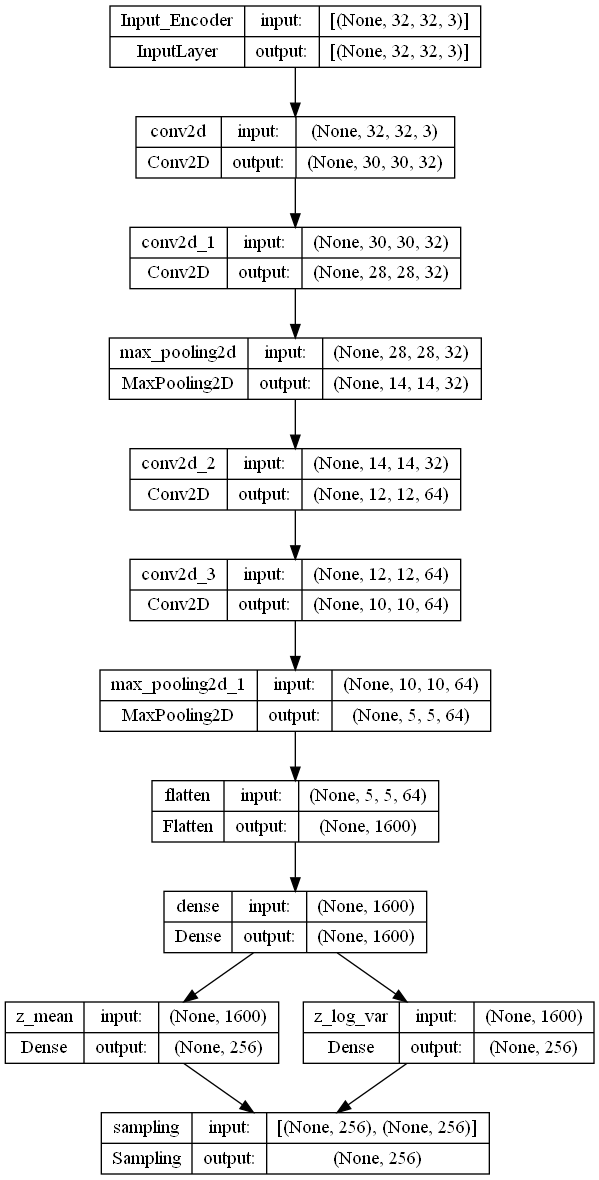

In [7]:
# Реализаця кодера
encoder_input = layers.Input(shape = input_dim, name="Input_Encoder");
print(encoder_input.shape)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(encoder_input)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='tanh')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
# x = tf.keras.layers.BatchNormalization()(x)
print(x.shape)
# x = tf.keras.layers.Conv2D(filters=256, kernel_size=7, strides=(2, 2), activation='relu')(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='tanh')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
# x = tf.keras.layers.BatchNormalization()(x)
print(x.shape)


# x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='tanh')(x)
# # x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='tanh')(x)
# x = tf.keras.layers.MaxPooling2D((2,2))(x)
# # x = tf.keras.layers.BatchNormalization()(x)
# print(x.shape)





x = tf.keras.layers.Flatten()(x)
print(x.shape)

x = tf.keras.layers.Dense(x.shape[1])(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)

z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



(None, 256)
(None, 8, 8, 4)
(None, 16, 16, 64)
(None, 32, 32, 32)
(None, 32, 32, 32)
(None, 32, 32, 32)
(None, 32, 32, 3)
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 reshape (Reshape)           (None, 8, 8, 4)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       50240     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 32)       401440    
 ranspose)                                                       
   

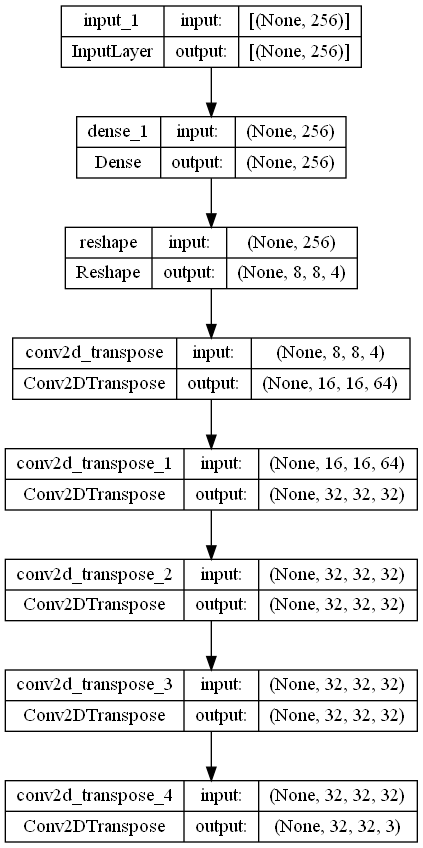

In [8]:
# Реализаця декодера
decoder_input = tf.keras.Input(shape=(latent_dim))

x =  tf.keras.layers.Dense(latent_dim)(decoder_input)
print(x.shape)

x = layers.Reshape((8, 8, 4))(x)
print(x.shape)
# x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
# # x = tf.keras.layers.BatchNormalization()(x)
# print(x.shape)
# x = layers.Conv2DTranspose(128, 14, activation="relu", strides=2, padding="same")(x)
# # x = tf.keras.layers.BatchNormalization()(x)
# print(x.shape)
x = layers.Conv2DTranspose(64, 14, activation="relu", strides=2, padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
print(x.shape)
x = layers.Conv2DTranspose(32, 14, activation="relu", strides=2, padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
print(x.shape)
x = layers.Conv2DTranspose(32, 14, activation="relu", strides=1, padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
print(x.shape)
x = layers.Conv2DTranspose(32, 14, activation="relu", strides=1, padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
print(x.shape)
decoder_outputs = layers.Conv2DTranspose(3, 14, activation="sigmoid", strides=1, padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
print(decoder_outputs.shape)
decoder = keras.Model(decoder_input, decoder_outputs, name="decoder")

decoder.summary()
plot_model(decoder, to_file='deocder.png', show_shapes=True, show_layer_names=True)

In [9]:
class CustomCallback(keras.callbacks.Callback):
    
    def __init__(self, validation_data = ()):
        super(keras.callbacks.Callback, self).__init__()
        self.X_val, self.y_val = validation_data
        self.log_loss = []
        self.log_val_loss = []
        self.log_reconstruction_loss = []
        self.KL_loss = []
        
    def on_epoch_end(self, epoch, logs={}):
        
        z_mean, z_log_var, z = self.model.encoder(self.X_val[0:10])
        reconstruction = self.model.decoder(z)
        
        score = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(self.X_val[0:10], reconstruction)
                )
            ) / len(self.X_val)
        
# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
#       Отображение графика
        self.log_loss.append(logs['loss'])
        self.log_val_loss.append(score)
        self.log_reconstruction_loss.append(logs['reconstruction_loss'])
        self.KL_loss.append(logs['kl_loss'])
        
        
        clear_output(wait=True)
        plt.close('all')
        fig = plt.figure(figsize=(30, 15))
        fig.clear()
        gs = GridSpec(nrows=4, ncols=2)

# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
        ax0 = fig.add_subplot(gs[0, 0])
        ax0.plot(range(1,epoch + 2),
        self.log_loss,
                label = 'loss')
        
#         ax0.plot(range(1,epoch + 2),
#                 self.log_val_loss,
#                 label = 'val_loss')
        
        ax0.plot(range(1,epoch + 2),
                self.log_reconstruction_loss,
                label = 'reconstruction_loss')
        ax0.set_ylabel('loss')
        ax0.set_xlabel('epochs')
#         ax0.legend()
        ax0.grid()

# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------



# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
#       # Second axes        
        ax1 = fig.add_subplot(gs[1, 0])
        ax1.plot(range(1,epoch + 2),
                self.KL_loss,
                label = 'KL_loss')
        
        ax1.set_ylabel('kl_loss')
        ax1.set_xlabel('epochs')
#         ax1.legend()
        ax1.grid()

# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
        
        
# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
# # Third axes
        ax2 = fig.add_subplot(gs[0:2, 1])
        ax2.imshow(tf.reshape(vae.decoder((tf.constant([np.random.rand(latent_dim) * 2 - 1 ]))),[32,32,3])) 
        ax2.set_title('Изображение из шума')
#         ax2.legend()
        ax2.grid()

# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------


        

# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
        ax3 = fig.add_subplot(gs[2, 0])
        dat = vae.encoder(tf.reshape(x_test[5],[1,32,32,3]))
        ax3.imshow(x_test[5])
        ax3.set_title('Тестовое изображение для сжатия')
#         ax3.legend()
        ax3.grid() 

# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
        ax4 = fig.add_subplot(gs[2, 1])
        ax4.set_title('Тестовое изображение после сжатия')
        ax4.imshow(tf.reshape(vae.decoder(dat[2]),[32,32,3])) 
#         ax4.legend()
        ax4.grid() 

# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
        ax5 = fig.add_subplot(gs[3, :])
        
        ax5.plot(range(1,epoch + 2),
                self.log_val_loss,
                label = 'val_loss')
        ax5.set_title('Ошибка востановления тестового изображения')
        ax5.set_ylabel('loss')
        ax5.set_xlabel('epochs')
#         ax5.legend()
        ax5.grid()
# ----------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------
#         fig.savefig(r'C:\Users\Nikita\Desktop\my_plot.png')
        fig.tight_layout()
        plt.show()
#         f, axs = plt.subplots(2, 2, figsize=(15,5))

        
        
#         axs[0,0].plot(range(1,epoch + 2),
#                 self.log_loss,
#                 label = 'loss')
        
#         axs[0,0].plot(range(1,epoch + 2),
#                 self.log_val_loss,
#                 label = 'val_loss')
        
#         axs[0,0].plot(range(1,epoch + 2),
#                 self.log_reconstruction_loss,
#                 label = 'reconstruction_loss')
#         axs[0,0].set_ylabel('loss')
#         axs[0,0].set_xlabel('epochs')
#         axs[0,0].legend()
#         axs[0,0].grid()
        
        
        

#         axs[0,1].imshow(tf.reshape(
#                                     vae.decoder(
#                                     (tf.constant([np.random.rand(latent_dim) * 2 - 1 ]))
#                                                ),[32,32,3]
#                                 )
#                      ) 
#         axs[0,1].legend()
#         axs[0,1].grid()
        
        
#         axs[1,0].plot(range(1,epoch + 2),
#                 self.KL_loss,
#                 label = 'KL_loss')
        
#         axs[1,0].set_ylabel('kl_loss')
#         axs[1,0].set_xlabel('epochs')
#         axs[1,0].legend()
#         axs[1,0].grid()
        
        
        
        
#         plt.tight_layout()
#         plt.show()        
# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------

        print('\r\n')
        print("interval evaluation (binary_crossentropy) - epoch: {:d} - score: {:.6f}".format(epoch, score))
        print('\r\n')
        print('------------------------------------------')

In [10]:
fig = plt.figure(figsize=(30, 15))


<Figure size 2160x1080 with 0 Axes>

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        
        
#   Отслеживание метрик
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    
    
    
# #   Функция генерации или декодирования значения
#     @tf.function
#     def sample(self, eps=None):
#         if eps is None:
#             eps = tf.random.normal(shape=(100, self.latent_dim))
#         return self.model.decode(eps, apply_sigmoid=True)

    
    
    
#   Обучение нейронной сети
    def train_step(self, data):
        
        data_len = tf.shape(data)
        data_len = tf.cast(data_len[0], tf.float32)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.1 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + kl_loss
#             total_loss = reconstruction_loss
            
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        
        self.total_loss_tracker.update_state(total_loss)
            
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            
        self.kl_loss_tracker.update_state(kl_loss)            
#         self.total_loss_tracker.update_state(total_loss)
#         self.reconstruction_loss_tracker.update_state(reconstruction_loss)
#         self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
   
    
    
# #   Функция репараметризации “reparameterization trick”
# #   https://arxiv.org/pdf/1606.05908.pdf стр.10
# #   Применяется для возможности дифферинцирования (обучения) модели
# #   по параметрам
#     def reparameterize(self, mean, logvar):
#         eps = tf.random.normal(shape=mean.shape)
#         return eps * tf.exp(logvar * .5) + meanj
    
    
    
    
# #   Функция декодирования с возможностью включения сигмоидной функции, 
# #      ограничивающей выходные данные
#     def decode(self, z, apply_sigmoid=False):
#         logits = self.decoder(z)
#         if apply_sigmoid:
#             probs = tf.sigmoid(logits)
#             return probs
#         return logits

In [12]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))
clbk = CustomCallback(validation_data=(x_test, x_test))

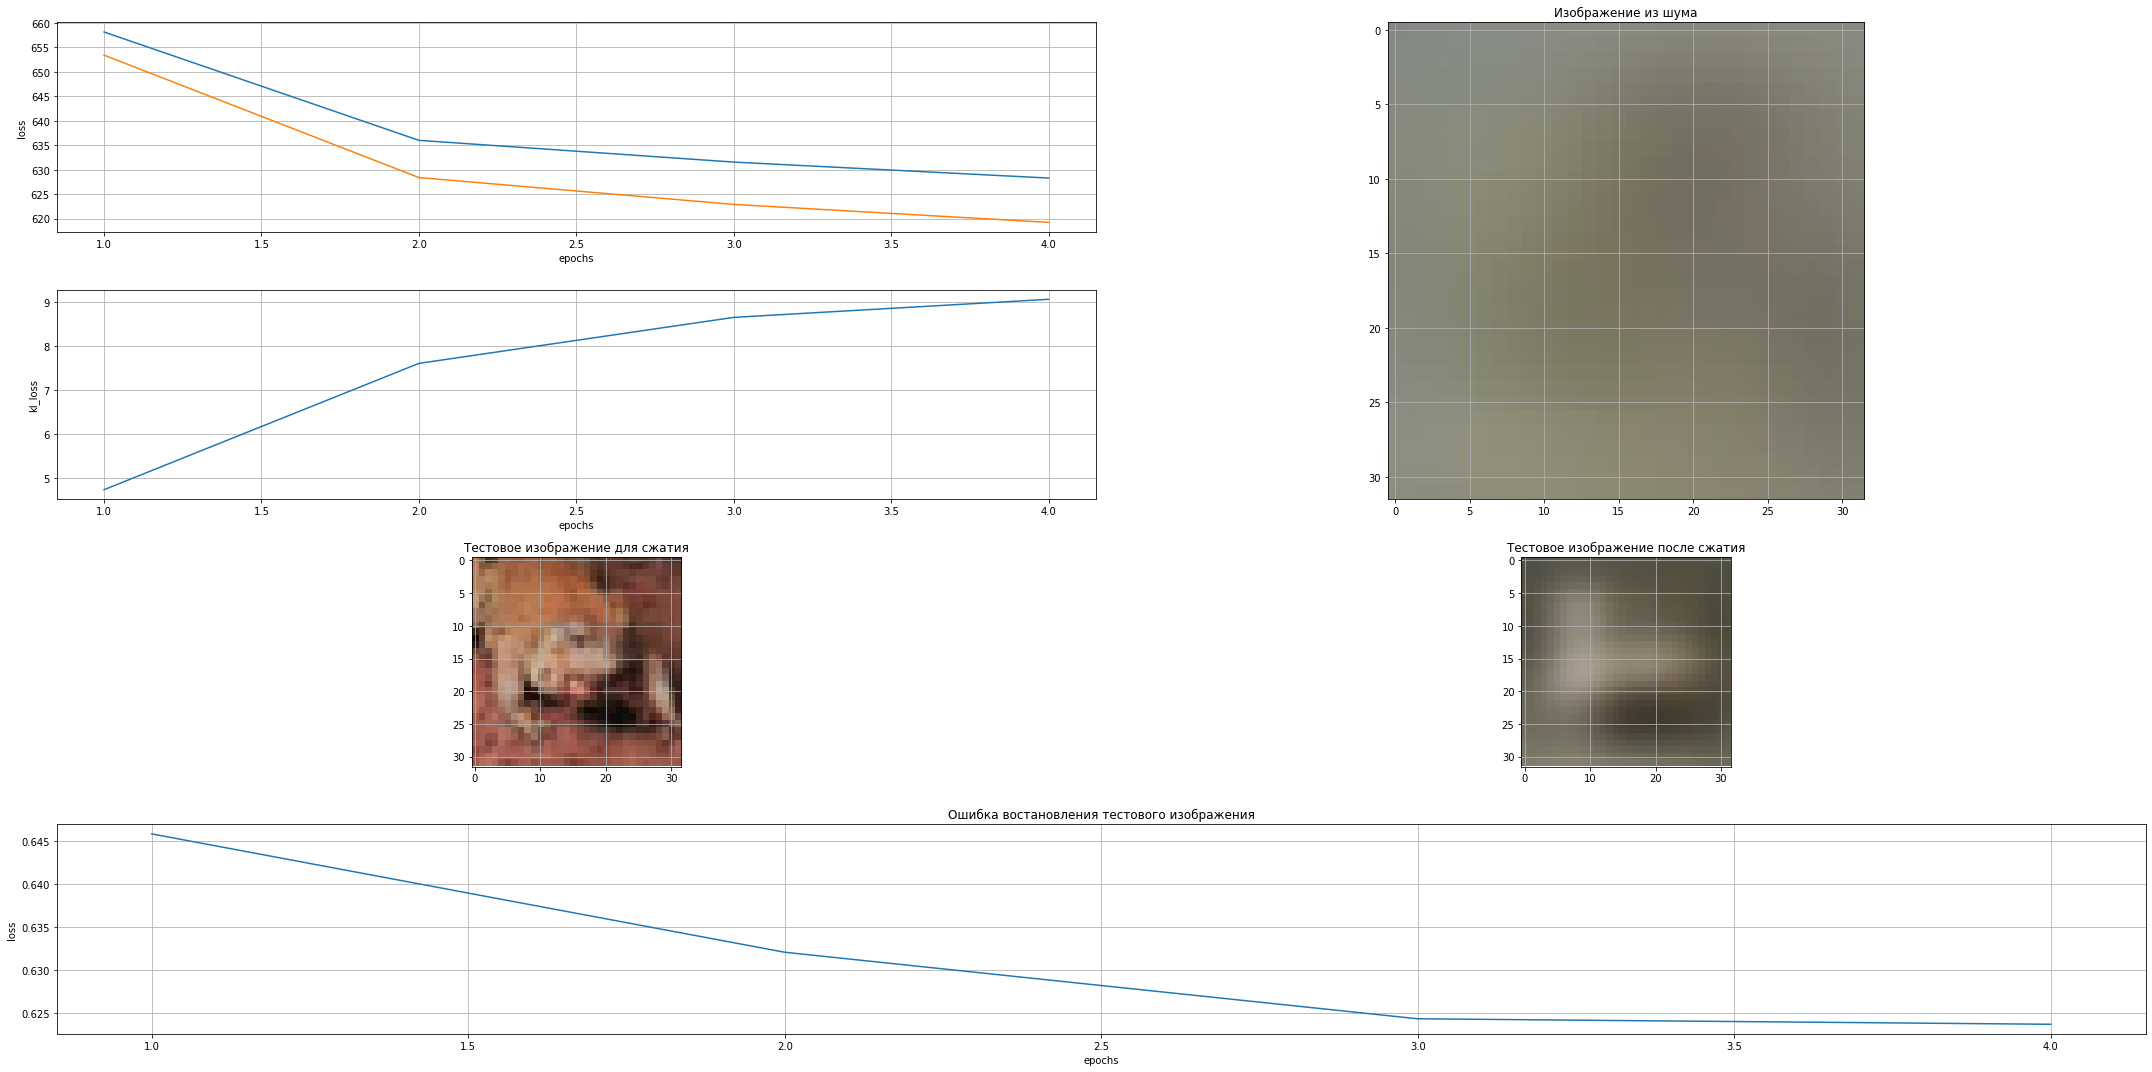



interval evaluation (binary_crossentropy) - epoch: 3 - score: 0.623654


------------------------------------------
4999/4999 [==============================] - 38s 8ms/step - loss: 628.5701 - reconstruction_loss: 619.2457 - kl_loss: 9.0608
Epoch 5/30
4024/4999 [=======================>......] - ETA: 7s - loss: 626.0082 - reconstruction_loss: 616.5163 - kl_loss: 9.0966

In [ ]:
fit_ = vae.fit(x_train[0:4999], epochs=30, batch_size=1, callbacks=[clbk])

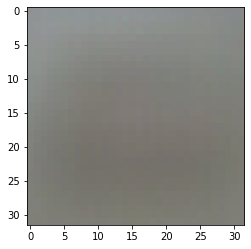

In [15]:
plt.imshow(
    tf.reshape(
        vae.decoder(
            (tf.constant([np.random.rand(latent_dim) * 2 - 1 ]))
                ),[32,32,3]
              )
          ) 
plt.show()

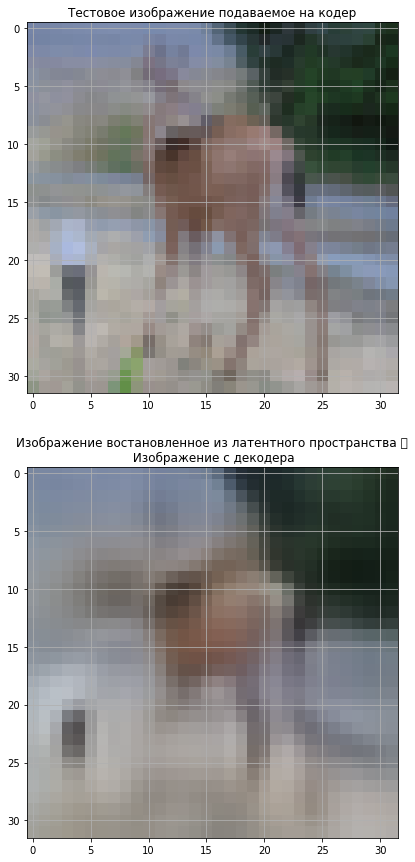

In [285]:
op = 100
dat = vae.encoder(tf.reshape(x_test[op],[1,32,32,3]))

fig, axes = plt.subplots(2, 1, figsize=(20,15))

axes[0].imshow(x_test[op])
axes[0].set_title('Тестовое изображение подаваемое на кодер')
axes[0].grid()


axes[1].imshow(
    tf.reshape(vae.decoder(dat[2]),[32,32,3])
          )
axes[1].set_title('Изображение востановленное из латентного пространства \r\n Изображение с декодера')
axes[1].grid()


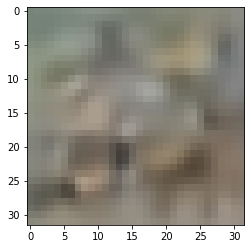

In [258]:
plt.imshow(tf.reshape(vae.decoder((tf.constant([np.random.rand(latent_dim) * 2 - 1 ]))),[32,32,3])) 

In [ ]:
num_count = 10
fig, axes = plt.subplots(num_count, 2, figsize=(20,15))
for i in range(num_count):
    

In [294]:
random.randint(0, 10)

AttributeError: 'builtin_function_or_method' object has no attribute 'randint'

In [156]:
tf.saved_model.save(vae,r'C:\Users\Nikita\Desktop\Stud\ConvVAE\model.save.h5')

TypeError: save() got an unexpected keyword argument 'save_format'

In [160]:
tf.keras.models.save_model(vae,r'C:\Users\Nikita\Desktop\Stud\ConvVAE\try_3_108epoch')

ValueError: Model <__main__.VAE object at 0x000002015B2BCFA0> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [159]:
model_loaded = tf.keras.models.load_model(r'C:\Users\Nikita\Desktop\Stud\ConvVAE\model.save\vae_v1')

ValueError: Unable to create a Keras model from SavedModel at C:\Users\Nikita\Desktop\Stud\ConvVAE\model.save\vae_v1. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.

In [161]:
load_vae = VAE(encoder, decoder)
load_vae.compile(optimizer=keras.optimizers.Adam(1e-4))


In [164]:
load_vae.load_weights(r'C:\Users\Nikita\Desktop\Stud\ConvVAE\')

SyntaxError: EOL while scanning string literal (1361916209.py, line 1)